# Preprocessing and Training Data Development - LendingClub Loan Listings Data

Meskerem Goshime

Data Source: https://www.kaggle.com/datasets/husainsb/lendingclub-issued-loans

“LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California.” The company “enables borrowers to create unsecured personal loans between 1,000𝑎𝑛𝑑 40,000. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.” (source: https://www.kaggle.com/datasets/husainsb/lendingclub-issued-loans?select=lc_2016_2017.csv)​

This study aims to help LendingClub in making informed lending decisions and investors make informed investment decisions

In [4]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# loading the loan 2007-2015 data
df = pd.read_csv('../data/interim/Loan_0715_after_eda.csv')
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,...,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,application_type,acc_now_delinq
0,1077501,5000.0,5000.0,4975.0,36,10.65,162.87,2,B2,10.0,...,861.07,0.00,0.00,0.00,Jan-2015,171.62,Jan-2016,0.0,INDIVIDUAL,0.0
1,1077430,2500.0,2500.0,2500.0,60,15.27,59.83,3,C4,0.0,...,435.17,0.00,117.08,1.11,Apr-2013,119.66,Sep-2013,0.0,INDIVIDUAL,0.0
2,1077175,2400.0,2400.0,2400.0,36,15.96,84.33,3,C5,10.0,...,603.65,0.00,0.00,0.00,Jun-2014,649.91,Jan-2016,0.0,INDIVIDUAL,0.0
3,1076863,10000.0,10000.0,10000.0,36,13.49,339.31,3,C1,10.0,...,2209.33,16.97,0.00,0.00,Jan-2015,357.48,Jan-2015,0.0,INDIVIDUAL,0.0
4,1075358,3000.0,3000.0,3000.0,60,12.69,67.79,2,B5,1.0,...,1009.07,0.00,0.00,0.00,Jan-2016,67.79,Jan-2016,0.0,INDIVIDUAL,0.0


In [6]:
# Converting the sub_grade column to numerical values to make the data useful in the modeling step.
# I am creating a numbering system where the subgrade values are evenly spaced out.
# This is not a perfect solution because I am making the assumption that the distance 
# between A1 and A2 or A5 and B1 is equal.

df['sub_grade'] = df['sub_grade'].replace(['A1', 'A2', 'A3', 'A4', 'A5'], [1.0, 1.2, 1.4, 1.6, 1.8])
df['sub_grade'] = df['sub_grade'].replace(['B1', 'B2', 'B3', 'B4', 'B5'], [2.0, 2.2, 2.4, 2.6, 2.8])
df['sub_grade'] = df['sub_grade'].replace(['C1', 'C2', 'C3', 'C4', 'C5'], [3.0, 3.2, 3.4, 3.6, 3.8])
df['sub_grade'] = df['sub_grade'].replace(['D1', 'D2', 'D3', 'D4', 'D5'], [4.0, 4.2, 4.4, 4.6, 4.8])
df['sub_grade'] = df['sub_grade'].replace(['E1', 'E2', 'E3', 'E4', 'E5'], [5.0, 5.2, 5.4, 5.6, 5.8])
df['sub_grade'] = df['sub_grade'].replace(['F1', 'F2', 'F3', 'F4', 'F5'], [6.0, 6.2, 6.4, 6.6, 6.8])
df['sub_grade'] = df['sub_grade'].replace(['G1', 'G2', 'G3', 'G4', 'G5'], [7.0, 7.2, 7.4, 7.6, 7.8])

In [7]:
# Checking the home_ownership column
df['home_ownership'].value_counts()

MORTGAGE    411789
RENT        332156
OWN          76388
OTHER          178
NONE            43
Name: home_ownership, dtype: int64

In [8]:
#combining mortgage and own categories
df['home_ownership'] = df['home_ownership'].str.replace('MORTGAGE', 'OWN')
df['home_ownership'].value_counts()

OWN      488177
RENT     332156
OTHER       178
NONE         43
Name: home_ownership, dtype: int64

In [9]:
# loan_status will be my target variable.
# Combining loan status values to 'good', which will be 0 or 'bad', which will be 1.

df['loan_status'].value_counts() 

# Good loans will be 0 and bad loans will be 1
df['loan_status']= df['loan_status'].replace(dict.fromkeys(['Current','Fully Paid','In Grace Period','Issued'], 0))
df['loan_status']= df['loan_status'].replace(dict.fromkeys(['Charged Off','Late (31-120 days)','Late (16-30 days)','Default'], 1))
df['loan_status'].value_counts()

0    763806
1     56748
Name: loan_status, dtype: int64

In [10]:
# number of bad loans by zipcode
status_zip = df.groupby('zip_code')['loan_status'].sum()
status_zip = pd.DataFrame(status_zip)
status_zip = status_zip.reset_index()
status_zip.sort_values(by='loan_status', ascending=False)
status_zip.columns = ['zip_code', '#bad_loans']

# total number of loans by zipcode
status_zip_count = df.groupby('zip_code')['loan_status'].count()
status_zip_count = pd.DataFrame(status_zip_count)
status_zip_count = status_zip_count.reset_index()
status_zip_count.columns = ['zip_code', 'loan_count']

# percentage of bad loans by zipcode and selecting with >= 10% of bad loans.
bad_loan_perc = pd.merge(status_zip, status_zip_count, left_on='zip_code', right_on='zip_code', how='left')
bad_loan_perc['perc_bad'] = bad_loan_perc['#bad_loans'] / bad_loan_perc['loan_count']
bad_loan_perc = bad_loan_perc[bad_loan_perc['perc_bad']>= 0.12]
bad_loan_perc

# selecting zipcodes with 50 or more loan records.
bad_loan_perc = bad_loan_perc[bad_loan_perc['loan_count']>=50].sort_values(by='perc_bad', ascending=False).reset_index()
bad_loan_perc.drop('index', axis=1)
bad_loan_perc

,index,zip_code,#bad_loans,loan_count,perc_bad
0,399,415xx,12,74,0.162162
1,687,736xx,12,83,0.144578
2,223,237xx,26,191,0.136126
3,115,126xx,28,209,0.133971
4,600,638xx,20,152,0.131579
5,628,668xx,13,105,0.123810


In [11]:
df.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'purpose', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d', 'collections_12_mths_ex_med', 'application_type',
       'acc_now_delinq'],
      dtype='object')

In [12]:
# Based on my exploration of the data, I am choosing some columns and dropping others.

# Columns to drop - funded_amnt, pymnt_plan, installment, verification_status, issue_d, addr_state, earliest_cr_line, 
# pub_rec, revol_bal, revol_util, total_acc, initial_list_status, out_prncp,
# out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries,
# collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, last_credit_pull_d, zip_code,

# Columns to use - loan_amnt, int_rate, 'grade', 'sub_grade', annual_inc, dti, delinq_2yrs, 
# inq_last_6mths, open_acc, collections_12_mths_ex_med, acc_now_delinq
# and the one-hot encoded columns

# I am leaving out the 'zip_code' column at this point. It is a categorical variable, but I do not want to do 
# one-hot-encoding on it since it has too many unique values. 

df = df[['loan_amnt', 'int_rate', 'grade', 'sub_grade', 'annual_inc', 'dti', 'delinq_2yrs', 
       'inq_last_6mths', 'open_acc', 'collections_12_mths_ex_med', 'acc_now_delinq', 
       'term', 'emp_length', 'home_ownership', 'application_type', 'purpose', 'loan_status']]


array([[<AxesSubplot:title={'center':'loan_amnt'}>,
        <AxesSubplot:title={'center':'int_rate'}>,
        <AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'sub_grade'}>],
       [<AxesSubplot:title={'center':'annual_inc'}>,
        <AxesSubplot:title={'center':'dti'}>,
        <AxesSubplot:title={'center':'delinq_2yrs'}>,
        <AxesSubplot:title={'center':'inq_last_6mths'}>],
       [<AxesSubplot:title={'center':'open_acc'}>,
        <AxesSubplot:title={'center':'collections_12_mths_ex_med'}>,
        <AxesSubplot:title={'center':'acc_now_delinq'}>,
        <AxesSubplot:title={'center':'term'}>],
       [<AxesSubplot:title={'center':'emp_length'}>,
        <AxesSubplot:title={'center':'loan_status'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

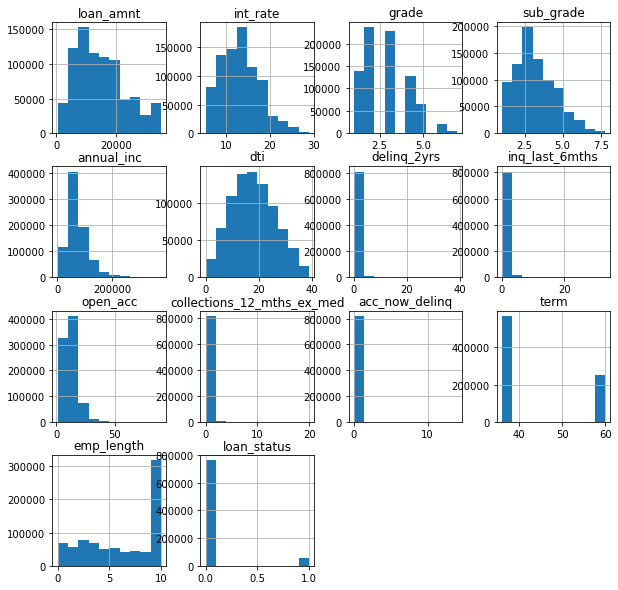

In [13]:
df.hist(figsize=(10,10), bins=10)

# One-hot-encoding Categorical Columns

In [14]:
# df = pd.get_dummies(df, prefix=['term', 'emp', 'home', 'appl', 'purpose'], columns=['term', 'emp_length', 'home_ownership', 'application_type', 'purpose'])
cat_cols = ['home_ownership', 'application_type', 'purpose']
df = pd.get_dummies(df, prefix=['home', 'appl', 'purpose'], columns=cat_cols)

In [15]:
df.columns

Index(['loan_amnt', 'int_rate', 'grade', 'sub_grade', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'term', 'emp_length',
       'loan_status', 'home_NONE', 'home_OTHER', 'home_OWN', 'home_RENT',
       'appl_INDIVIDUAL', 'appl_JOINT', 'purpose_car', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding'],
      dtype='object')

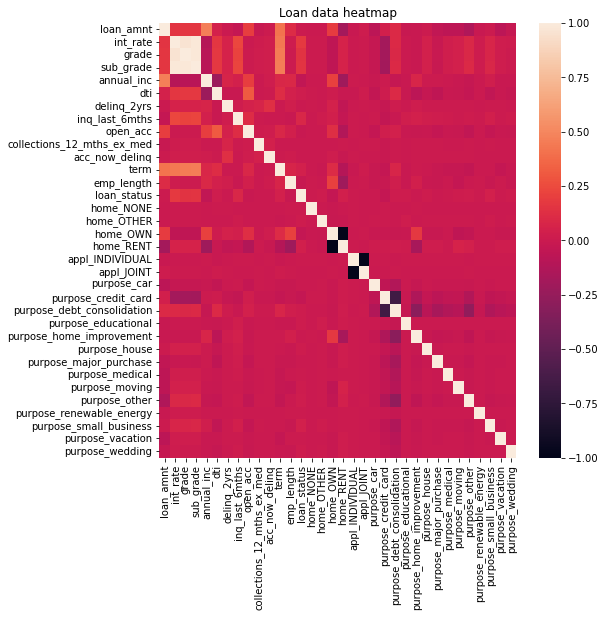

In [16]:
plt.figure(figsize=(8,8))
heat_map = sns.heatmap(df.corr())
plt.title( "Loan data heatmap" )
plt.show()

# Splitting the data into training set and test set

In [17]:
# Dividing the data into X and y

X = df.drop(['loan_status'], axis=1)
y = df[['loan_status']]

In [18]:
# Splitting the data into training and testing set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Standardizing the numeric columns using StandardScaler

In [19]:
from sklearn.preprocessing import StandardScaler
numeric_cols = df.select_dtypes(include='number')
print(numeric_cols.columns)

scaler = StandardScaler()
to_standardize = ['loan_amnt', 'int_rate', 'grade', 'sub_grade', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'term', 'emp_length']

scaler.fit(X_train[to_standardize])
standardized_cols_train = scaler.transform(X_train[to_standardize])
standardized_cols_train = pd.DataFrame(standardized_cols_train)
standardized_cols_train.columns = to_standardize


Index(['loan_amnt', 'int_rate', 'grade', 'sub_grade', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'term', 'emp_length',
       'loan_status', 'home_NONE', 'home_OTHER', 'home_OWN', 'home_RENT',
       'appl_INDIVIDUAL', 'appl_JOINT', 'purpose_car', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding'],
      dtype='object')


In [20]:
standardized_cols_train.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,656443.0,1.609655e-16,1.000001,-1.708755,-0.778737,-0.199333,0.608862,2.391644
int_rate,656443.0,-1.666653e-16,1.000001,-1.809071,-0.743513,-0.059000,0.673429,3.591736
grade,656443.0,-4.029284e-17,1.000001,-1.365890,-0.604579,0.156731,0.918041,3.201972
sub_grade,656443.0,-8.861360e-16,1.000001,-1.683999,-0.760369,-0.144616,0.625076,3.549904
annual_inc,656443.0,-4.872111e-16,1.000001,-1.736566,-0.660490,-0.231053,0.365389,7.260249
dti,656443.0,-1.044544e-15,1.000001,-2.204958,-0.748915,-0.055795,0.703453,2.578307
delinq_2yrs,656443.0,1.360344e-14,1.000001,-0.366546,-0.366546,-0.366546,-0.366546,44.887591
inq_last_6mths,656443.0,-7.188053e-15,1.000001,-0.696715,-0.696715,-0.696715,0.303337,32.304974
open_acc,656443.0,-5.545509e-17,1.000001,-1.995416,-0.677329,-0.112435,0.452460,14.763115
collections_12_mths_ex_med,656443.0,-1.043881e-14,1.000001,-0.108918,-0.108918,-0.108918,-0.108918,76.771351


In [21]:
not_to_standardize = ['home_NONE', 'home_OTHER', 'home_OWN', 
       'home_RENT', 'appl_INDIVIDUAL', 'appl_JOINT',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding']

X_train = X_train[not_to_standardize]

# Combining the standardized columns and the categorical columns that don't need standardization.

X_train.reset_index(drop=True, inplace=True)
standardized_cols_train.reset_index(drop=True, inplace=True)
X_train = pd.concat([standardized_cols_train, X_train], axis=1) 

In [22]:
X_train.head(3)

,loan_amnt,int_rate,grade,sub_grade,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,collections_12_mths_ex_med,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,2.391644,-0.930613,-0.604579,-0.760369,4.182613,-1.146909,-0.366546,-0.696715,0.264161,-0.108918,...,0,0,0,0,0,0,0,0,0,0
1,0.014601,0.169171,0.156731,0.317199,0.007524,0.423021,-0.366546,0.303337,-0.865627,-0.108918,...,0,0,1,0,0,0,0,0,0,0
2,-0.698512,-0.015647,0.156731,0.163261,0.079097,-0.576248,-0.366546,-0.696715,-0.865627,-0.108918,...,0,0,0,0,0,1,0,0,0,0


In [23]:
# Standardizing the test data

standardized_cols_test = scaler.transform(X_test[to_standardize])
standardized_cols_test = pd.DataFrame(standardized_cols_test)
standardized_cols_test.columns = to_standardize
X_test = X_test[not_to_standardize]

# Combining the standardized columns and the categorical columns that don't need standardization.

X_test.reset_index(drop=True, inplace=True)
standardized_cols_test.reset_index(drop=True, inplace=True)
X_test = pd.concat([standardized_cols_test, X_test], axis=1)
X_test.head(3)


,loan_amnt,int_rate,grade,sub_grade,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,collections_12_mths_ex_med,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,0.430583,-0.743513,-0.604579,-0.606431,-0.899067,1.127163,-0.366546,-0.696715,0.640758,-0.108918,...,0,0,0,0,0,0,0,0,0,0
1,2.391644,2.323106,2.440662,2.164459,1.725275,0.274845,-0.366546,5.303592,1.958844,-0.108918,...,0,0,0,0,0,0,0,0,0,0
2,1.975661,0.166890,0.156731,0.163261,0.031382,0.861426,-0.366546,-0.696715,-0.300733,-0.108918,...,0,0,0,0,0,0,0,0,0,0


In [26]:
X_train.to_csv('../data/processed/X_train.csv', index=False)
X_test.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

In [27]:
df.to_csv('../data/processed/df_before_split.csv', index=False)